Note: DeepMIMO data: BS16, row3500_3516, 3.4 GHz

In [1]:
import torch
import torch.nn as nn


import os
import sys
import numpy as np
from scipy.io import savemat

# Add the Torch_code directory to the Python path
# sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append(os.path.abspath('../helper'))
import config
import utils
import loader
import plotfig
# import skfuzzy as fuzz

In [2]:
# FILE_PATH = os.path.dirname(os.path.abspath("__file__"))
# print(FILE_PATH)
# print(config.temp_path)
# print(config.FILE_PATH)

In [3]:
# Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32 #64  # Batch size
NUM_EPOCHS = 50 # 20

# rows from DeepMIMO dataset settings
# change rows according to the .mat dataset file 
rows = [['3500', '3516']] 
fc = '3p4' #Hz can change to '60'
rowss = "3500_3516"
learning_rate = 1e-5 
SNR = np.arange(0, 31, 5) # 0:5:30 dB
outer_file_path = os.path.abspath(os.path.join(config.FILE_PATH, 
                        '..', 'DeepMIMOv2', 'DeepMIMO_Data', 'Static_BS16', 'freq_symb_1ant_612sub_ver4'))


In [4]:
norm_approach = 'minmax' # can be set to 'std'
lower_range = -1 
    # if norm_approach = 'minmax': 
        # =  0 for scaling to  [0 1]
        # = -1 for scaling to [-1 1]
    # if norm_approach = 'std': can be any value, but need to be defined
    
if norm_approach == 'minmax':
    if lower_range == 0:
        norm_txt = 'Using min-max [0 1]'
    elif lower_range ==-1:
        norm_txt = 'Using min-max [-1 1]'
elif norm_approach == 'no':
    norm_txt = 'No'
    
CNN_activation = 'Tanh'
CNN_DropOut = 0.2
if CNN_DropOut != 0:
    dropOut_txt = f'Add p={CNN_DropOut} DropOut'
# create readme.txt file
content = f"""Generated by file 'train/static_CNN_lr1e-5_v16_(...).ipynb'.
Correspond with BS16, 3.4 GHz fc, rows {rowss},
Data got from {outer_file_path},
Learning rate {learning_rate}, {NUM_EPOCHS} epochs
{norm_txt} scaler for each sample
Using {CNN_activation} as activation function of CNN
{dropOut_txt}
7 conv layers, slowly reduce number of layers
"""


In [5]:
# Paths to save
idx_save_path = loader.find_incremental_filename('../model/static/CNN/BS16/'+ rowss,'ver', '_', '')
model_path = '../model/static/CNN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'
figure_path = '../figure/static/CNN/BS16/' + rowss + '/ver' + str(idx_save_path) + '_/readme.txt'

if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))
if not os.path.exists(os.path.dirname(figure_path)):
    os.makedirs(os.path.dirname(figure_path))

# Open the file in write mode ('w'). If the file does not exist, it will be created.
with open(model_path, 'w') as file:
    # Write the content to the file
    file.write(content)

with open(figure_path, 'w') as file:
    # Write the content to the file
    file.write(content)

print(f"File '{model_path}' and ' {figure_path} ' created and content written.")

save_folder_model = os.path.join(config.FILE_PATH, 'model/static/CNN', 'BS16', rowss, 'ver' + str(idx_save_path) + '_')
save_folder_fig = os.path.join(config.FILE_PATH, 'figure', 'static', 'CNN', 'BS16' ,  rowss, 'ver' + str(idx_save_path) +'_')

File '../model/static/CNN/BS16/3500_3516/ver21_/readme.txt' and ' ../figure/static/CNN/BS16/3500_3516/ver21_/readme.txt ' created and content written.


In [6]:
nmse_LS_LI_val   = []
nmse_LS_NN_val   = []
nmse_LI_NN_val   = []

In [7]:
for snr in SNR:
    print(f" SNR: {snr}/{SNR[-1]}")

    [trainLabels, valLabels], [H_equal_train, H_linear_train, H_practical_train], [H_equal_val, H_linear_val, H_practical_val] = loader.load_data(outer_file_path, rows, fc, device, snr)

    # -----------------------------------------------------
    # 1. When input is H_linear (after LS+LI)
    print(f" Training for LS+LI")
    # [samples, 2, 612, 14]
    train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_linear_train, trainLabels, BATCH_SIZE, device, 'train', True, norm_approach, lower_range=lower_range)
    val_loader,     valLabel_min,   valLabel_max = loader.genLoader(H_linear_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach, lower_range=lower_range)
        # no shuffle in validation so valLabel_min and valLable_max remain the min and max arrays
                                                                                    # of valLabels
        # train_loader, val_loader are already normalized by their own min, max
        # scale to range [0 1]
        
    # model
    model = utils.CNN_Est2(dropOut=CNN_DropOut, act =CNN_activation).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
    criterion = nn.MSELoss()

    # 1.5 Training loop
    train_loss =[]
    val_loss = []
    H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
    min_H_true = []
    max_H_true = []
    num_epochs = NUM_EPOCHS
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        if (epoch == num_epochs-1):
            i = 0
        for inputs, targets, targets_min, targets_max in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        print(f"SNR: {snr}/{SNR[-1]}, LS+LI, Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
        
        # Validation 
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets, val_targetsMin, val_targetsMax in val_loader:
                val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
                val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
                val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
                val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
                
                val_outputs_real = model(val_inputs_real)
                val_loss_real = criterion(val_outputs_real, val_targets_real)
                running_val_loss += val_loss_real.item()
                
                val_outputs_imag = model(val_inputs_imag)
                val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
                running_val_loss += val_loss_imag.item()
                
                if (epoch == num_epochs-1): # the results after the last training 
                    H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                    H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                    
                    i = i+val_outputs_imag.size(0)       
                    
                
        avg_val_loss = running_val_loss / (len(val_loader)*2)
        val_loss.append(avg_val_loss)    
                
        print(f"SNR: {snr}/{SNR[-1]}, LS+LI, Val Loss: {avg_val_loss}")


    save_folder = os.path.join(save_folder_model, str(snr)+'dB')
    os.makedirs(save_folder, exist_ok=True)
    index_save = loader.find_incremental_filename(save_folder, 'CNN_', '_variable')

    model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LS_LI_CNN_model.pth')
    variable_save_path = os.path.join(save_folder, 'CNN_' +str(index_save)+'_variable.pth')
    params_save_path = os.path.join(save_folder, 'CNN_' +str(index_save)+'_params.mat')
    
    params = {   
                'SNR': snr,
                'epoc': NUM_EPOCHS,
                'rows': rowss,
                'learning_rate': learning_rate,
                'train_track_LI': train_loss,
                'val_track_LI': val_loss,
    }
    variables = {             
                'train_track_LI': train_loss,
                'val_track_LI': val_loss,
                # 'train_min_LI': trainData_min.cpu(),
                # 'train_max_LI': trainData_max.cpu(),
                # 'train_label_min': trainLabels_min.cpu(),
                # 'train_label_max': trainLabels_max.cpu(),
    }
    # variable to save 
    # Save the models' state dictionaries 
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
        }, model_save_path)

    figure_save_path = os.path.join(save_folder_fig, str(snr) + 'dB') 
    
    os.makedirs(figure_save_path, exist_ok=True)

    plotfig.figLoss(train_loss, val_loss, index_save, figure_save_path, '_LS_LI_Loss.png')


    # True channel
    H_val_true = valLabels.cpu()
    # convert to complex matrices
    H_val_true_complex = torch.complex(H_val_true[:,0,:,:], H_val_true[:,1,:,:])
    # variables['H_val_true'] = H_val_true # (nVal, 2, 612, 14)

    plotfig.figTrueChan(H_val_true[-1,0,:,:], 'True Channel', index_save, figure_save_path, '_trueChannel.png')

    # Estimated Channel 
    H_val_NN = H_NN_val.cpu()    
    plotfig.figTrueChan(H_val_NN[-1,0,:,:], 'LI+CNN Estimated Channel (before de-normlized)', 
                            index_save, figure_save_path, '_LS_LI_CNN_estimatedChan_before_denorm.png')

    # De-normalized                                                               
    H_val_NN_denormd = utils.deNorm(H_NN_val, valLabel_min, valLabel_max, norm_approach, lower_range=lower_range)
                        #     H_NN_val == [nVal, 2, 612, 14] 
                        # valLabel_min == [nVal,1]
                        
    H_val_NN_denormd = H_val_NN_denormd.cpu()
    # variables['H_val_LI_NN'] = H_val_NN_denormd # (nVal, 2, 612, 14)

    # convert to complex matrices
    H_val_NN_denormd_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
    
    nmse_LI_NN = utils.calNMSE(H_val_NN_denormd_complex, H_val_true_complex)
    
    variables['NMSE_LI_NN'] = nmse_LI_NN.cpu().mean()
    nmse_LI_NN_val.append(variables['NMSE_LI_NN'].item())
    print(f"LI+NN NMSE: {variables['NMSE_LI_NN'].item()}")
    
    plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LI+CNN Estimated Channel (after de-normlized)',
                            nmse_LI_NN[-1], index_save, figure_save_path, '_LS_LI_CNN_estimatedChan.png')
#####
##### above is LS+LI+NN 

##### following is Linear interpolated channel (only LS+LI)
    H_val_linInterp = H_linear_val.cpu()
    # convert to complex matrices
    H_val_linInterp_complex = torch.complex(H_val_linInterp[:,0,:,:], H_val_linInterp[:,1,:,:]) # [?, 612, 14]

    # NMSE of Linear Interpolation
    # Calculate the NMSE
    nmse_LI = utils.calNMSE(H_val_linInterp_complex, H_val_true_complex)
    
    variables['NMSE_LI'] = nmse_LI.cpu().mean()
    nmse_LS_LI_val.append(variables['NMSE_LI'].item())
    print(f"LS+LI NMSE: {variables['NMSE_LI'].item()}")
    
    plotfig.figPredChan(H_val_linInterp[-1,0,:,:], 'LS + Interpolate Estimated Channel',
                            nmse_LI[-1], index_save, figure_save_path, '_LS_LI_estimatedChan.png')


##########################################
    # ------------------------------------------------------
    # When Input of the NN is just H_equalized
    print(f" Training for LS")
    # [samples, 2, 612, 14]
    H_LS_train = H_equal_train.cpu()
    plotfig.figTrueChan(H_LS_train[0,0,:,:], 'LS Channel', index_save, figure_save_path, '_LS_Chan.png')
    
    # Split into training and validation sets for H_NN training
    train_loader, trainLabel_min, trainLabel_max = loader.genLoader(H_equal_train, trainLabels, BATCH_SIZE, device, 'train',  True, norm_approach)
    val_loader,     valLabel_min,   vallabel_max = loader.genLoader(H_equal_val,     valLabels, BATCH_SIZE, device, 'valid', False, norm_approach)


    model2 = utils.CNN_Est2(dropOut=0, act =CNN_activation).to(device)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate) 
    criterion = nn.MSELoss()

    # Training loop
    train_loss =[]
    val_loss = []
    H_NN_val = torch.empty_like(valLabels) # [nVal, 2, 612, 14]
    num_epochs = NUM_EPOCHS
    for epoch in range(num_epochs):
        model2.train()
        running_loss = 0.0
        if (epoch == num_epochs-1):
            i = 0
        for inputs, targets, targets_min, targets_max in train_loader:
            optimizer2.zero_grad()
            outputs = model2(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer2.step()
            running_loss += loss.item()
            
        avg_train_loss = running_loss / len(train_loader)
        train_loss.append(avg_train_loss)
        print(f"SNR: {snr}/{SNR[-1]}, LS, Epoch {epoch+1}/{num_epochs}, Loss: {avg_train_loss} ")
        
        # Validation 
        model2.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for val_inputs, val_targets, val_targetsMin, val_targetsMax in val_loader:
                val_inputs_real = val_inputs[:,0,:,:].unsqueeze(1)
                val_inputs_imag = val_inputs[:,1,:,:].unsqueeze(1)
                val_targets_real = val_targets[:,0,:,:].unsqueeze(1)
                val_targets_imag = val_targets[:,1,:,:].unsqueeze(1)
                
                val_outputs_real = model2(val_inputs_real)
                val_loss_real = criterion(val_outputs_real, val_targets_real)
                running_val_loss += val_loss_real.item()
                
                val_outputs_imag = model2(val_inputs_imag)
                val_loss_imag = criterion(val_outputs_imag, val_targets_imag)
                running_val_loss += val_loss_imag.item()
                
                if (epoch == num_epochs-1):
                    H_NN_val[i:i+val_outputs_real.size(0),0,:,:].unsqueeze(1).copy_(val_outputs_real)
                    H_NN_val[i:i+val_outputs_imag.size(0),1,:,:].unsqueeze(1).copy_(val_outputs_imag)
                    i = i+val_outputs_imag.size(0)
                
        avg_val_loss = running_val_loss / (len(val_loader)*2)
        val_loss.append(avg_val_loss)    
                
        print(f"SNR: {snr}/{SNR[-1]}, LS, Val Loss: {avg_val_loss}")

    plotfig.figLoss(train_loss, val_loss, index_save, figure_save_path, '_LS_Loss.png')

    # De-normalized                                                                
    H_val_NN_denormd = utils.deNorm(H_NN_val, valLabel_min, valLabel_max, norm_approach, lower_range=lower_range)
                        #     H_NN_val == [nVal, 2, 612, 14] 
                        # valLabel_min == [nVal,1]
    H_val_NN_denormd = H_val_NN_denormd.cpu()

    model_save_path = os.path.join(save_folder,  'CNN_' +str(index_save)+'_LS_CNN_model.pth')

    # variables['H_val_LS_NN']= H_val_NN_denormd.cpu() # (nVal, 2, 612, 14)
    variables['train_track_LS']= train_loss
    variables['val_track_LS']= val_loss

    # Save parameters
    params['train_track_LS']= train_loss
    params['val_track_LS']= val_loss
    savemat(params_save_path, params)
    # Save the models' state dictionaries 
    torch.save({'model_state_dict': model2.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, model_save_path)


    # NMSE of LS + NN
    H_val_LS_NN_complex = torch.complex(H_val_NN_denormd[:,0,:,:], H_val_NN_denormd[:,1,:,:])
    # Calculate the NMSE
    nmse_LS_NN = utils.calNMSE(H_val_LS_NN_complex, H_val_true_complex)
    
    variables['NMSE_LS_NN'] = nmse_LS_NN.cpu().mean()
    nmse_LS_NN_val.append(variables['NMSE_LS_NN'].item())
    print(f"LS+LI NMSE: {variables['NMSE_LS_NN'].item()}")
    
    plotfig.figPredChan(H_val_NN_denormd[-1,0,:,:], 'LS+CNN Estimated Channel (after de-normlized)',
                            nmse_LS_NN[-1], index_save, figure_save_path, '_LS_CNN_estimatedChan.png')
    

    torch.save( variables,variable_save_path)

 SNR: 0/30
 Training for LS+LI


/home/thien/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 612, 14])) that is different to the input size (torch.Size([32, 16, 612, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


SNR: 0/30, LS+LI, Epoch 1/50, Loss: 0.1465491134413453 


/home/thien/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([5, 1, 612, 14])) that is different to the input size (torch.Size([5, 16, 612, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


SNR: 0/30, LS+LI, Val Loss: 0.058276082135059616
SNR: 0/30, LS+LI, Epoch 2/50, Loss: 0.05914111392096032 
SNR: 0/30, LS+LI, Val Loss: 0.0365788366814906
SNR: 0/30, LS+LI, Epoch 3/50, Loss: 0.03946967115409152 
SNR: 0/30, LS+LI, Val Loss: 0.02959821567955342
SNR: 0/30, LS+LI, Epoch 4/50, Loss: 0.03489687370656188 
SNR: 0/30, LS+LI, Val Loss: 0.02807574143463915
SNR: 0/30, LS+LI, Epoch 5/50, Loss: 0.03254659437076297 
SNR: 0/30, LS+LI, Val Loss: 0.027229553935202686
SNR: 0/30, LS+LI, Epoch 6/50, Loss: 0.03132130982094379 
SNR: 0/30, LS+LI, Val Loss: 0.02703163120895624
SNR: 0/30, LS+LI, Epoch 7/50, Loss: 0.030200414516594866 
SNR: 0/30, LS+LI, Val Loss: 0.02677733163264665
SNR: 0/30, LS+LI, Epoch 8/50, Loss: 0.029481075530828432 
SNR: 0/30, LS+LI, Val Loss: 0.026136296716603367
SNR: 0/30, LS+LI, Epoch 9/50, Loss: 0.028925722562383082 
SNR: 0/30, LS+LI, Val Loss: 0.025764149867675522
SNR: 0/30, LS+LI, Epoch 10/50, Loss: 0.02850937417729996 
SNR: 0/30, LS+LI, Val Loss: 0.025911429812285034

RuntimeError: output with shape [32, 1, 612, 14] doesn't match the broadcast shape [32, 16, 612, 14]

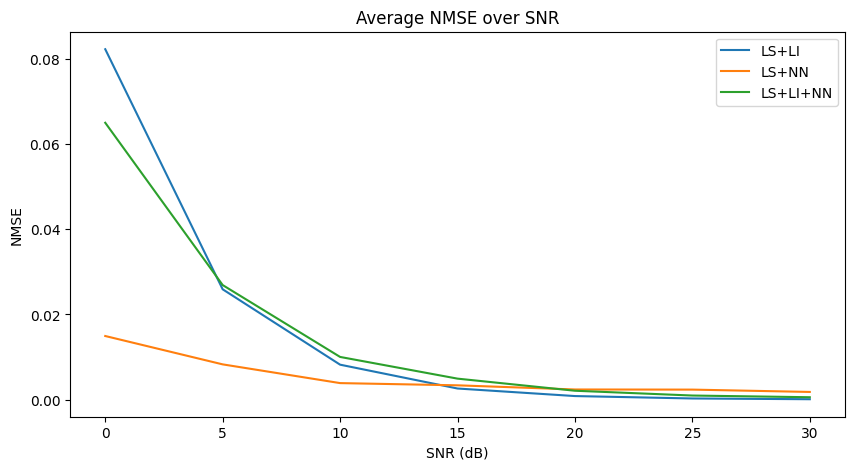

Figure saved at 
/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/figure/static/CNN/BS16/3500_3516/ver15_/NMSE1.png


In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LS_NN_val, label='LS+NN')
plt.plot(SNR, nmse_LI_NN_val, label='LS+LI+NN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Average NMSE over SNR')
plt.legend()
plt.savefig(os.path.join(save_folder_fig, "NMSE1.png"))
plt.show()
print('Figure saved at ')
print(os.path.join(save_folder_fig, "NMSE1.png"))

savemat(os.path.join(save_folder_fig, 'NMSE.mat'), {'nmse_LS_LI_val': nmse_LS_LI_val, 'nmse_LS_NN_val':nmse_LS_NN_val, 'nmse_LI_NN_val':nmse_LI_NN_val})

nmse_compare ={
    'nmse_LS_LI_val': nmse_LS_LI_val, 
    'nmse_LS_NN_val':nmse_LS_NN_val, 
    'nmse_LI_NN_val':nmse_LI_NN_val
}
torch.save( nmse_compare, os.path.join(save_folder_fig, 'NMSE.pth'))

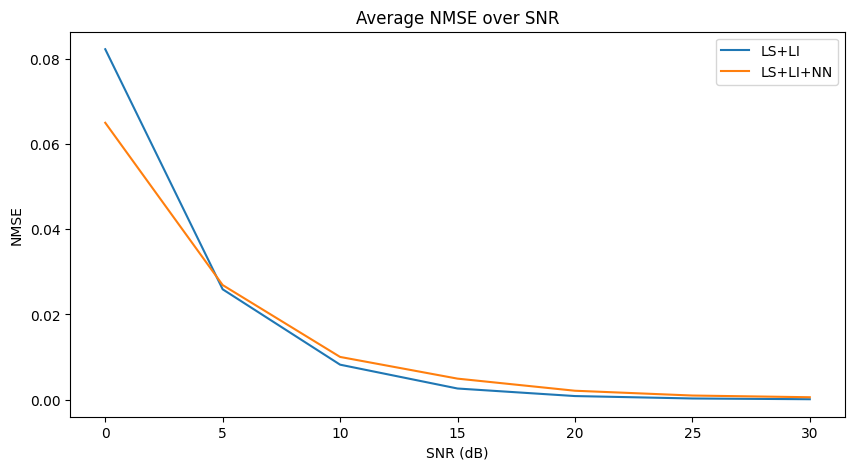

Figure saved at 
/home/thien/Hprediction/one_shot_Hest_cleanver/Torch_code/figure/static/CNN/BS16/3500_3516/ver15_/NMSE2.png


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(SNR, nmse_LS_LI_val, label='LS+LI')
plt.plot(SNR, nmse_LI_NN_val, label='LS+LI+NN')
plt.xlabel('SNR (dB)')
plt.ylabel('NMSE')
plt.title('Average NMSE over SNR')
plt.legend()
plt.savefig(os.path.join(save_folder_fig, "NMSE2.png"))
plt.show()
print('Figure saved at ')
print(os.path.join(save_folder_fig, "NMSE2.png"))